In [ ]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd

In [10]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# Declare a Base using `automap_base()`
Base = automap_base()

# reflect an existing database into a new model
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

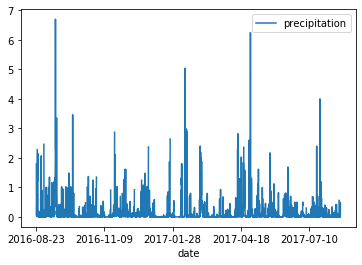

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first() # date of last data point in database is 2017-08-23
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True, )

# Sort the dataframe by date
df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()

In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

In [79]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [52]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_list = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all() 
for row in station_list:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [60]:
# USC00519281 has the highest number of observations based on the results of the above query
top = station_list[0][0]
print(top)

USC00519281


In [65]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max = session.query(func.max(Measurement.tobs).filter(Measurement.station==top)).all()
min = session.query(func.min(Measurement.tobs).filter(Measurement.station==top)).all()
avg = session.query(func.avg(Measurement.tobs).filter(Measurement.station==top)).all()

print(f'Max temp for {top} is: {max[0][0]}')
print(f'Min temp for {top} is: {min[0][0]}')
print(f'Average temp for {top} is: {avg[0][0]}')

Max temp for USC00519281 is: 85.0
Min temp for USC00519281 is: 54.0
Average temp for USC00519281 is: 71.66378066378067


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C74EA580F0>]],
      dtype=object)

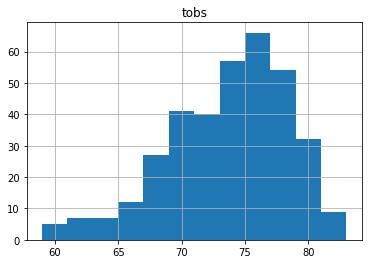

In [75]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).filter(Measurement.station==top).order_by(Measurement.date.desc()).first() # date of last data point for top station is 2017-08-18
top_query_date = dt.date(2017, 8, 18) - dt.timedelta(days=365)

top_results = session.query(Measurement.tobs).\
    filter(Measurement.station==top).\
    filter(Measurement.date >= top_query_date).all()

# Save the query results as a Pandas DataFrame
top_df = pd.DataFrame(top_results, columns=['tobs'])

top_df.hist(column='tobs',bins=12)

session.close()

## Bonus Challenge Assignment

In [80]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
